In [37]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import random
import cv2


In [36]:
train_dir='./chest_Xray/train'
test_dir='./chest_Xray/test'
val_dir='./chest_Xray/val'

def sample_count(direct,dirname):
    sub_dir = os.listdir(direct)
    for direc in sub_dir:
            classpath=os.path.join(direct, direc)
            filelist = os.listdir(classpath)
            print(f"Number of samples in {dirname} directory for {direc} is {len(filelist)}")  

sample_count(train_dir,"training")
sample_count(test_dir,"testing")
sample_count(val_dir,"validation")

Number of samples in training directory for NORMAL is 1341
Number of samples in training directory for PNEUMONIA is 3876
Number of samples in testing directory for NORMAL is 234
Number of samples in testing directory for PNEUMONIA is 390
Number of samples in validation directory for NORMAL is 9
Number of samples in validation directory for PNEUMONIA is 9


Average height and width of images in ./chest_Xray/train/NORMAL is 18524 and 22364 respectively, with aspect ratio 0.8283278901392933
Average height and width of images in ./chest_Xray/train/PNEUMONIA is 31969 and 46518 respectively, with aspect ratio 0.6872453983061451
Average height and width of images in ./chest_Xray/test/NORMAL is 3203 and 4212 respectively, with aspect ratio 0.7604772225004807
Average height and width of images in ./chest_Xray/test/PNEUMONIA is 2984 and 4449 respectively, with aspect ratio 0.6708224606166039
{'train': {'normal': {'height': 18524, 'width': 22364, 'aspect ratio': 0.8283278901392933}, 'pneumonia': {'height': 31969, 'width': 46518, 'aspect ratio': 0.6872453983061451}}, 'test': {'normal': {'height': 3203, 'width': 4212, 'aspect ratio': 0.7604772225004807}, 'pneumonia': {'height': 2984, 'width': 4449, 'aspect ratio': 0.6708224606166039}}}
(1673, 2358, 3)
Total height and width of images in training set is 34508 and 45623 respectively, with aspect ratio 

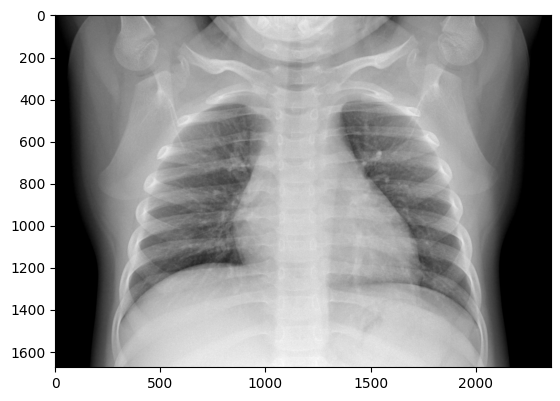

In [50]:

def avg_height_width(train_normal_path):
    filelist = os.listdir(train_normal_path)
    ht,wt=0,0
    for x in filelist:
        img_path = os.path.join(train_normal_path,x )
        img=plt.imread(img_path)
        shape=img.shape
        ht += shape[0]
        wt += shape[1]
    print(f"Average height and width of images in {train_normal_path} is {ht//100} and {wt//100} respectively, with aspect ratio {ht/wt}")
    return {'height': ht//100, 'width': wt//100, 'aspect ratio': ht/wt}

train_normal_path = './chest_Xray/train/NORMAL'
train_pneumonia_path = './chest_Xray/train/PNEUMONIA'
test_normal_path = './chest_Xray/test/NORMAL'
test_pneumonia_path = './chest_Xray/test/PNEUMONIA'

average_height_width_train = {
    "train":{
        'normal': avg_height_width(train_normal_path),
        'pneumonia': avg_height_width(train_pneumonia_path)
    },
    "test":{
        'normal': avg_height_width(test_normal_path),
        'pneumonia': avg_height_width(test_pneumonia_path)
    }
}

print(average_height_width_train)

test_img = cv2.imread(os.path.join(train_normal_path,filelist[0] ))
plt.imshow(test_img)
print(test_img.shape)
average_total_height = ave
print(f"Total height and width of images in training set is {total_height} and {total_width} respectively, with aspect ratio {total_height/total_width}")